# Setup

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgrammar as xgr
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig

# We use Qwen2.5-1.5B, a state-of-the-art small language model.
# It fits easily in memory (approx 3GB RAM).
model_id = "Qwen/Qwen2.5-0.5B-Instruct"  # Qwen/Qwen2.5-1.5B-Instruct

print(f"Loading {model_id}...")
tokenizer = AutoTokenizer.from_pretrained(model_id)
config = AutoConfig.from_pretrained(model_id)

# We use the specific xgrammar tokenizer info wrapper
tokenizer_info = xgr.TokenizerInfo.from_huggingface(
    tokenizer,
    vocab_size=config.vocab_size
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float32 # Use bfloat16 if on GPU/MPS
)

Loading Qwen/Qwen2.5-0.5B-Instruct...


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


# Data generation

In [2]:
# Crash scenario: Sales were steady, then crashed.
# Context: A supplier email explains a delay.

# A. Numerical Data (The "Chart")
dates = pd.date_range("2024-01-01", periods=14, freq="D")
sales = [100, 102, 98, 105, 101, 99, 103, 45, 42, 40, 41, 38, 39, 40] # The crash starts day 8
df = pd.DataFrame({"Date": dates, "Sales": sales})

# Format the series as a text string for the LLM
series_str = df.to_string(index=False)

# B. Textual Data (The "Context")
email_context = """
FROM: supplier@logistics.com
SUBJECT: Shipment Delay Notification
DATE: 2024-01-07

Dear Partner, 
Due to a severe storm at the port, your inventory shipment (Batch #902) 
has been delayed by 2 weeks. We expect to resume normal delivery by Jan 25th.
"""

# Define a Schema

In [3]:
# We define the JSON structure. 
# This forces the model to pick EXACTLY one of the allowed options,
# preventing it from hallucinating.

decision_schema = """
{
  "type": "object",
  "properties": {
    "observed_anomaly": { "type": "string" },
    "email_insight": { "type": "string" },
    "root_cause": { "type": "string", "enum": ["SUPPLY_SHOCK", "DEMAND_DROP"] },
    "marketing_action": { "type": "string", "enum": ["PAUSE_MARKETING", "INCREASE_MARKETING"] }
  },
  "required": ["observed_anomaly", "email_insight", "root_cause", "marketing_action"]
}
"""

# Compile the grammar
grammar_compiler = xgr.GrammarCompiler(tokenizer_info)
compiled_grammar = grammar_compiler.compile_json_schema(decision_schema)

# Create the Logits Processor (The Enforcer)
xgr_logits_processor = xgr.contrib.hf.LogitsProcessor(compiled_grammar)

# The Agent

In [4]:
user_prompt = f"""
DATA CONTEXT:
{series_str}

TEXT CONTEXT:
{email_context}

LOGIC RULES:
1. If root_cause is "SUPPLY_SHOCK" (cannot ship items) -> marketing_action MUST be "PAUSE_MARKETING".
2. If root_cause is "DEMAND_DROP" (customers not buying) -> marketing_action MUST be "INCREASE_MARKETING".

TASK:
Analyze the data around Jan 8th. Correlate with the email.
Determine the root cause based on the text.
Select the marketing action by strictly applying the LOGIC RULES above.
"""

messages = [{"role": "user", "content": user_prompt}]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
text += "{"

inputs = tokenizer(text, return_tensors="pt").to(model.device)

# Qualitative Inference

In [5]:
output_ids = model.generate(
    **inputs,
    max_new_tokens=256,
    do_sample=True,
    logits_processor=[xgr_logits_processor] 
)

# Decode output
generated = output_ids[0][inputs.input_ids.shape[-1]:]
print("{" + tokenizer.decode(generated, skip_special_tokens=True))

{{"observed_anomaly":"The shipment was delayed due to a severe storm at the port.","email_insight":"The supplier's inventory shipment (Batch #902) has been delayed by 2 weeks.","root_cause":"SUPPLY_SHOCK","marketing_action":"PAUSE_MARKETING"}


# Visualization

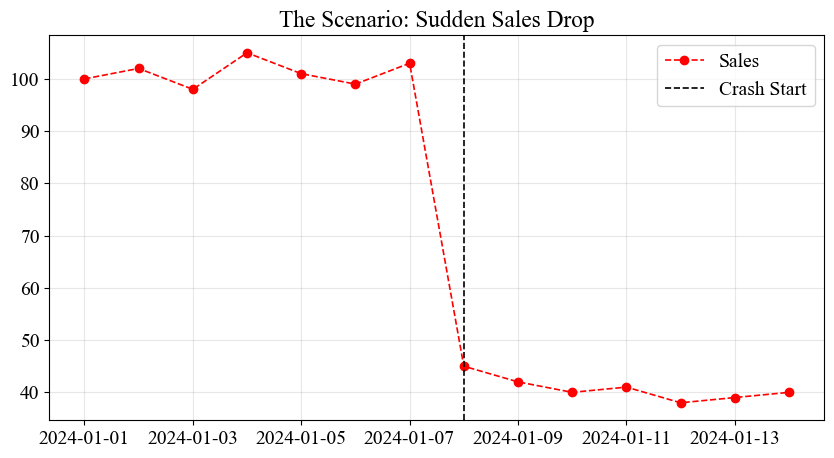

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["Sales"], marker='o', color='red', label="Sales")
plt.axvline(pd.Timestamp("2024-01-08"), color="black", linestyle="--", label="Crash Start")
plt.title("The Scenario: Sudden Sales Drop")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()